# Tutorial 7
## Outline
* Principal components analysis
* Combining dimensionality reduction with GMM: A generative application
* More on Pytorch
    * See number of params in a model
    * Dropout
    * L1 and L2 regularization
    * Trainer class
* MNIST Dataset
* Q&A on HW6

## Principal components analysis (PCA)
Calculating PCA just follows a simple procedure of doing a singular value decomposition on the covariance matrix $X^TX$:
$$X^TX=P\Lambda P^{-1}$$
where $X$ is the normalized data matrix (#data points $\times$ #features), $P$ is an orthogonal matrix and $\Lambda$ is a diagonal matrix.

Let's work on the Iris dataset again.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("iris.csv")
X = df.drop("variety", axis=1)
X.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Using PCA function from sklearn
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
x_pca = pca.fit_transform(X)
x_pca.shape

(150, 4)

Let's take a look at the explained ratio

In [5]:
pca.explained_variance_ratio_

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

In [6]:
pca = PCA(n_components=3)
x_pca = pca.fit_transform(X)
x_pca.shape

(150, 3)

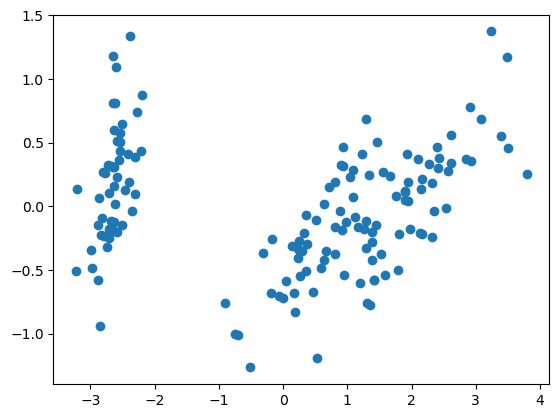

In [7]:
plt.scatter(x_pca[:,0],x_pca[:,1])

Visualize data before PCA

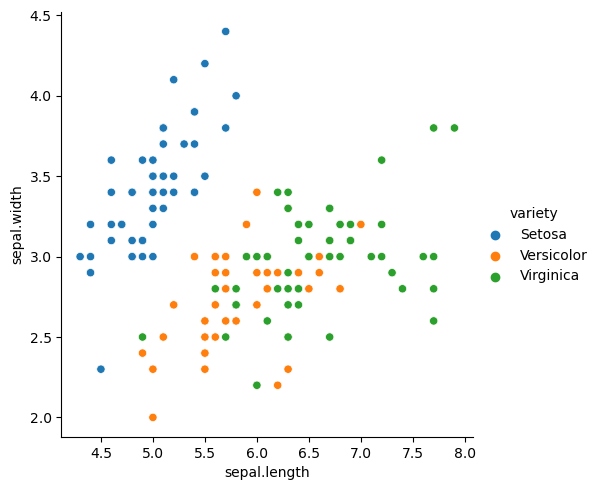

In [8]:
import seaborn as sns
ax1 = sns.relplot(data=X, x="sepal.length", y="sepal.width",hue=df['variety'])

Visualize data after PCA

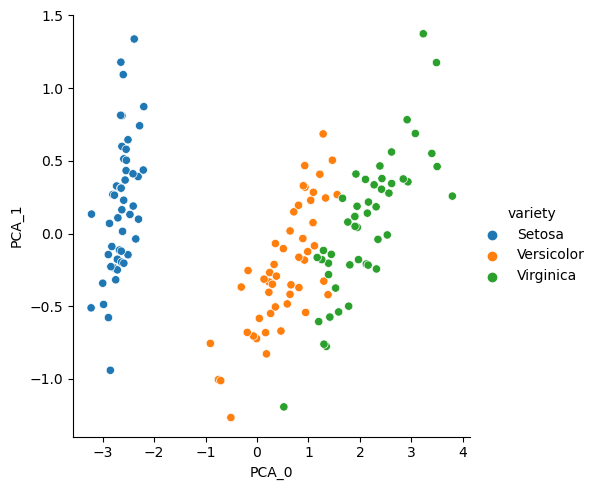

In [9]:
X_pca = pd.DataFrame(x_pca,index = df.index,columns = [f'PCA_{i}' for i in range(len(pca.explained_variance_ratio_))])
ax2 = sns.relplot(data=X_pca, x="PCA_0", y="PCA_1",hue=df['variety'])

## PCA+GMM for handwriting digit generation
(Credit: [Link](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html))<br>
Gaussian mixture model (GMM) is also a generative model, by which means we can sample from the fitted distribution to generate new data that is similar to the data used for fitting. Today we will try to apply GMM to the principle components of hand-written digits for generating more!

In [10]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

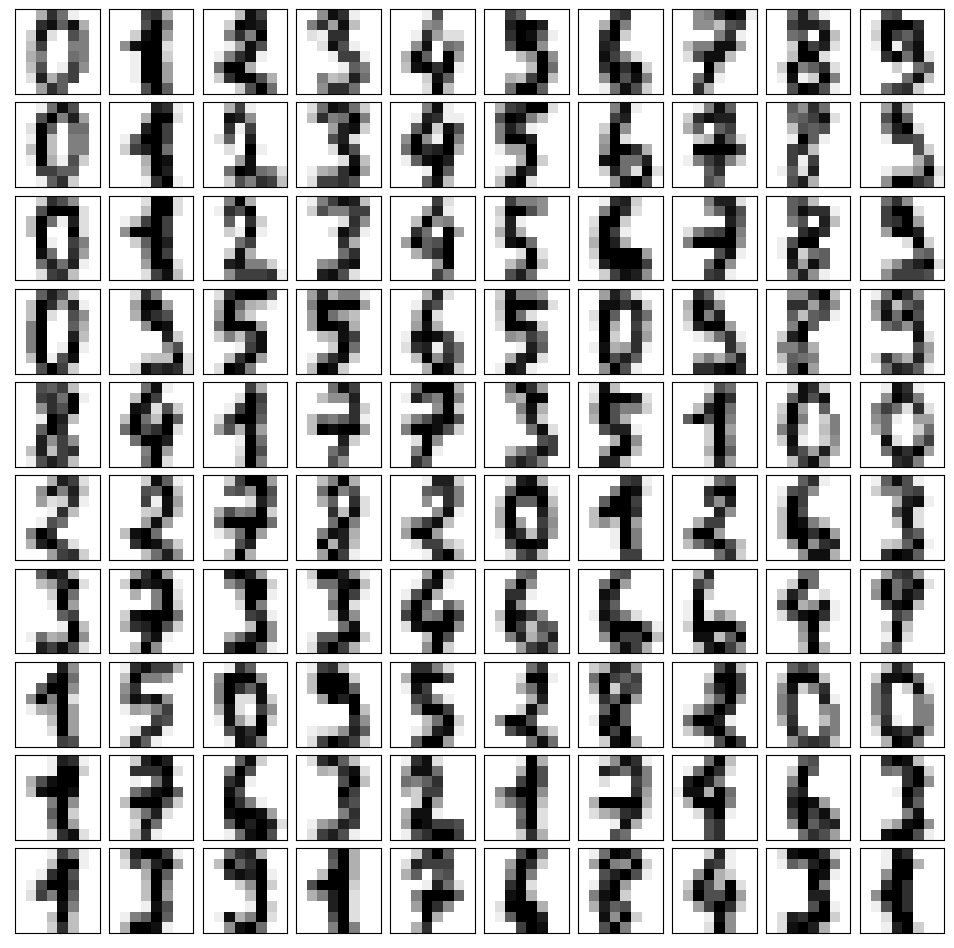

In [11]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(12, 12),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Here we apply principal component analysis on the 64-dimensional input data to do dimensionality reduction

In [12]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

We will use the GaussianMixture model ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)) from sklearn to fit the data and do sampling.

In [13]:
from sklearn.mixture import GaussianMixture
gmm=GaussianMixture(n_components=10)
gmm.fit(data)

GaussianMixture(n_components=10)

In [14]:
data_new,new_class = gmm.sample(100)
data_new.shape

(100, 41)

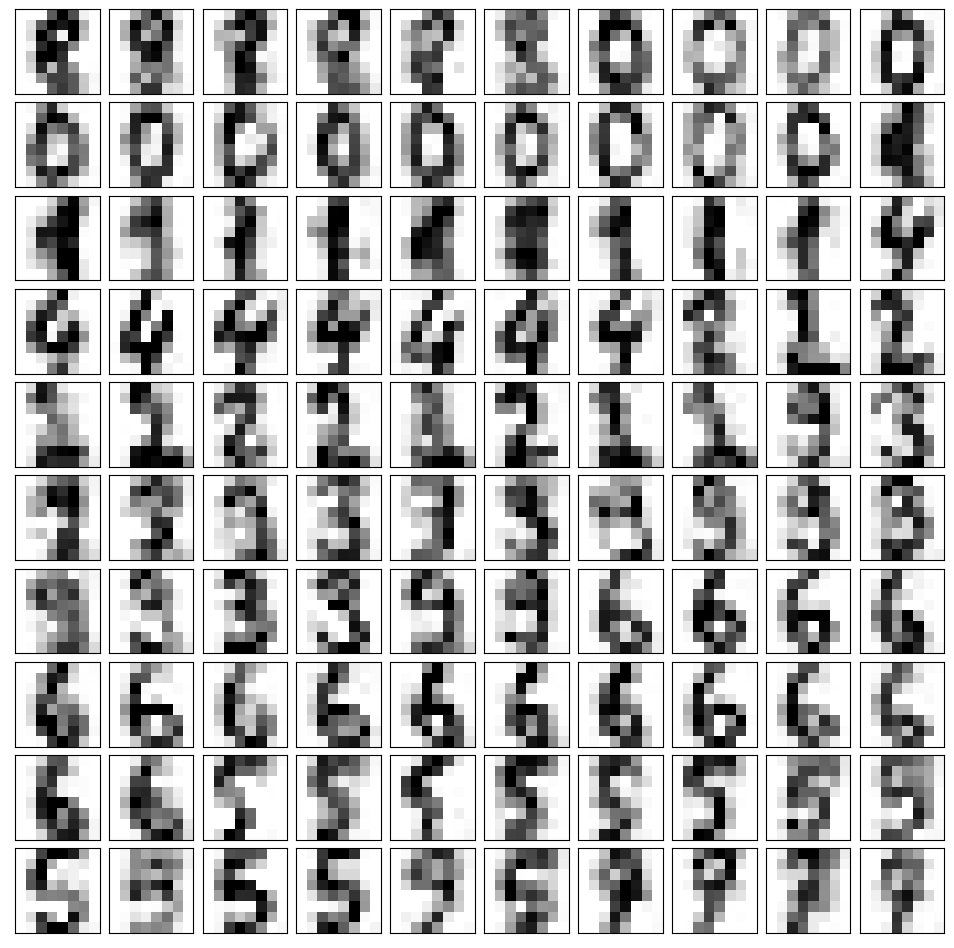

In [15]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

# More on Pytorch

Let's design a network that recognize the hand written digits!

### nn.ModuleList vs nn.Sequential

In [16]:
from torch import nn
import torch

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(41, 32),     # XW^T = X_2 (n, 32) [10000, 1000, 10000000, 1000] called gradient vanishing
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 10),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)
    
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(41, 32), nn.Linear(32, 16), nn.Linear(16, 10)])
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(2):
            x = self.fc[i](x)
            x = self.activation(x)
        x = nn.Softmax(dim=-1)(self.fc[-1](x))
        return x

### Print number of parameters

In [17]:
mlpnet = MLPNet()
print("MLPNet parameters:", sum([len(item.flatten()) for item in mlpnet.parameters()]))

MLPNet parameters: 2042


In [18]:
mlp = MLP()
print("MLP parameters:", sum([len(item.flatten()) for item in mlp.parameters()]))

MLP parameters: 2042


### Dropouts

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(41, 32),     # XW^T = X_2 (n, 32) [10000, 1000, 10000000, 1000] called gradient vanishing
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 10),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.layers(x)

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(41, 32), nn.Linear(32, 16), nn.Linear(16, 10)])
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        for i in range(2):
            x = self.fc[i](x)
            x = self.dropout(x)
            x = self.activation(x)
        x = nn.Softmax(dim=-1)(self.dropout(self.fc[-1](x)))
        return x

### L1/L2 regularization

You can modify your loss function to achieve the L1/L2 regularization. <br>
L1 regularization: $Loss = Error(Y - \widehat{Y}) + \lambda \sum_1^n |w_i|$ <br>
L2 regularization: $Loss = Error(Y - \widehat{Y}) +  \lambda \sum_1^n w_i^{2}$

In [9]:
loss = loss_fn(outputs, labels)
l1_lambda = 0.001
l1_norm = sum([p.abs().sum() for p in model.parameters()])
loss = loss + l1_lambda * l1_norm

NameError: name 'loss_fn' is not defined

In [10]:
l2_norm = sum([p.pow(2.0).sum() for p in model.parameters()])

NameError: name 'model' is not defined

## Trainer class

In [1]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks  

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size,):
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
        self.epoch = epoch
        self.batch_size = batch_size

    def train(self, inputs, outputs, validation_size=0.2):
        inputs, val_inputs, outputs, val_outputs = train_test_split(inputs, outputs, test_size=validation_size)
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)

        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        for n_epoch in range(self.epoch):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            # Mini Batch
            for batch in tqdm(batch_indices, leave=False):
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                batch_predictions = self.model(batch_input)   # N, 10-dimensional
                ### loss function of your choice ###
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.detach().item() * batch_importance
                ### compute accuracy of classification ###
                y = torch.argmax(batch_predictions, axis=-1)
                acc = torch.sum(pred == batch_output) / len(batch_predictions)   # (T, F, T, F)
                epoch_acc += acc.detach().item() * batch_importance
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
            print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)


        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute prediction and loss###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            y = torch.argmax(batch_predictions, axis=-1)
            batch_acc = torch.sum(pred == batch_output) / len(batch_predictions)   # (T, F, T, F)
            losses += loss.detach().item() * batch_importance
            acc += batch_acc.detach().item() * batch_importance
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [2]:
mlp_trainer = Trainer(mlpnet, "adam", 1e-3, 30, 128)
log = mlp_trainer.train(data, digits.target)

NameError: name 'mlpnet' is not defined